# Constraints Diagram
### AVD Group 16
Aero Year 4 2019-2020
Last updated: 2019.10.17

In [1]:
import numpy as np
import array as arr
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import fluids

## Function returns CLmax, Cd, e based on configuration and gear

In [2]:
def flap(config=None, gear=False):
    """function returns tuple of cl, cd, e with input configuration and gear option
    Args:
        config (str): flap configuration (basically comes from flaps angles)
            If set to None, clean config. is returned
        gear (bool): gear option
    Returns:
        (tuple): tuple of cl, cd, e
    """
    # Airfoil choice: NACA23015
    # >> factor of 0.9 is multiplied into cl to account for 3D airfoil correction
    
    # clean configuration
    sweep = 30*np.pi/180
    cL = 0.9*1.729*np.cos(sweep)
    cD = 0.02
    e = 0.9
    
    
    
    cratio = 1.3
    #dcl = 1.3 #slotted/fowler
    dcl = 1.6 #double slotted
    
    
    Sflapped_Sref = 0.6
    dcL = 0.9*dcl*np.cos(sweep)
    
    
    if config == 'takeoff':
        # 10 degree
        cL += dcL
        cL = 0.8*cL
        cD += 0.02
        e -= 0.05
        
    if config == 'approach':
        # 20
        cL += dcL
        cL = 0.9*cL
        cD += 0.02
        e -= 0.05
    
    if config == 'landing':
        # 45
        cL += dcL
        cD += 0.04
        e -= 0.07
    
    # append if gear is down
    if gear:
        cD += 0.02
        e -= 0.1
    
    return cL, cD, e

# print all configurations
cl, cd, e = flap(config='clean', gear=False)
print(f'clean cl, cd, e: {cl, cd, e}')

cl, cd, e = flap(config='takeoff', gear=False)
print(f'takeoff cl, cd, e: {cl, cd, e}')

cl, cd, e = flap(config='takeoff', gear=True)
print(f'takeoff with gear cl, cd, e: {cl, cd, e}')

cl, cd, e = flap(config='approach', gear=False)
print(f'approach cl, cd, e: {cl, cd, e}')

cl, cd, e = flap(config='landing', gear=False)
print(f'landing cl, cd, e: {cl, cd, e}')

cl, cd, e = flap(config='landing', gear=True)
print(f'landing with gear cl, cd, e: {cl, cd, e}')

clean cl, cd, e: (1.347622130828965, 0.02, 0.9)
takeoff cl, cd, e: (2.075758969822846, 0.04, 0.85)
takeoff with gear cl, cd, e: (2.075758969822846, 0.06, 0.75)
approach cl, cd, e: (2.3352288410507014, 0.04, 0.85)
landing cl, cd, e: (2.594698712278557, 0.06, 0.8300000000000001)
landing with gear cl, cd, e: (2.594698712278557, 0.08, 0.7300000000000001)


In [3]:
0.9*1.729*np.cos(30*np.pi/180)

1.347622130828965

## Inputs related to aircraft parameters

In [4]:
# Reference data from CRJ700
#Sref     = 70.6    # m2
#b        = 23.2    # m wingspan
Kld      = 11      # stand. value for retractable prop aircraft
SwetSref = 5.7     # Estimated value

#AR       = b**2/Sref
AR = 8            # FIXME!!! - Weight sizing uses 8!!!

print('Aspect ratio: {}'.format(AR))

# conversion ratio
ft2m = 0.3048
ms2knots = 1.94384449

# physical constants
g     = 9.81

# Initialize array of WSo
WSo  = np.linspace(1,8100,100+1)


Aspect ratio: 8


## List of $\alpha$ and functions to calculate  $\beta$

In [5]:
# List of alphas from GPKit notebook
# this is [M_0, M_1, M_2, ..., M_8, M_9, M_dry
# M_9 is the mass at the end of landing and taxi, M_dry is different due to assumed 6% ullage
# ------------------------- #
# M_0   = alpha_list[0]  - taxi and takeoff
# M_1   = alpha_list[1]  - climb and accelerate
# M_2   = alpha_list[2]  - cruise for 2,000 km at Mach 0.75
# M_3   = alpha_list[3]  - descent to land
# M_4   = alpha_list[4]  - missed approach climb
# M_5   = alpha_list[5]  - cruise to alternate dest.
# M_6   = alpha_list[6]  - loiter at 1,500 m for 45 min
# M_7   = alpha_list[7]  - descent to land
# M_8   = alpha_list[8]  - landing & taxi
# M_9   = alpha_list[9]  - end of landing & taxi (with fuel left over)
# M_dry = alpha_list[10] - dry mass
# ------------------------- #
alpha_list = [1.0,
 0.9700000000217274,
 0.9554500000424797,
 0.8662240940895669,
 0.8618929736379425,
 0.8489645790521038,
 0.8346511478768818,
 0.8137373076948168,
 0.8096686211740269,
 0.8056202780857528,
 0.7600191302870707]


In [6]:
# Function calculates betas
def calc_beta(z):
    """
    Function calculates beta's for different altitudes # FIXME - should also have dependencies on speed/Mach?
    Args:
        z (float): altitude in meters
    Returns:
        (float): value of beta
    """
    #Z is assumed to be in meters
    atm = fluids.atmosphere.ATMOSPHERE_1976(z)
    atm0 = fluids.atmosphere.ATMOSPHERE_1976(0)
    P = atm.P
    P0 = atm0.P
    sigma = P/P0
    return sigma**0.7

## Function to calculate T/W_0 = f( W_0/S )
Use same equation (full version for twin jet), re-assign values to parameters for each scenario

$ \left( \dfrac{T}{W} \right)_0 = \dfrac{\alpha}{\beta} \left[ \dfrac{1}{V_{inf}}\dfrac{dh}{dt} + \dfrac{1}{g}\dfrac{dV_{inf}}{dt} + \dfrac{\tfrac{1}{2}\rho V_{inf}^2 C_{D_0}}{\alpha \tfrac{W_0}{S_{ref}}} + \dfrac{\alpha n^2 \tfrac{W_0}{S_{ref}}}{\tfrac{1}{2} \rho V_{inf}^2 \pi AR e} \right] $

In [7]:
# Define function (T/W)_0 = fn(S/W0, etc.)
def TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e,split=False):
    """
    Function calculates T/W for given S/W
    Args:
        WSo (array): list of WSo at which T/W is to be computed
        alpha (float): W/W0 
        beta (float): T/T0
        dhdt (float): climb rate [m/s]
        dvdt (float): acceleration rate [m/s^2]
        rho (float): air density at altitude [kg/m^3]
        Vinf (float): true airspeed [m/s]
        Cdo (float): zero-lift drag
        n (float): load factor
        AR (float): aspect ratio
        e (float): oswald defficiency
        split (bool): if set to True, return functions output element-wise
    Returns:
        (array): values of function output (i.e. (T/W)o) evaluated for each element in WSo
    """
    g = 9.81
    
    # calculate term-by-term
    term_climb = (1/Vinf)*dhdt
    term_accel = (1/g)*dvdt
    term_cdo = (.5*rho*Vinf**2*Cdo)/(alpha*WSo)
    term_cdi = (alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)
    
    # sum all terms of the equation
    TW = (alpha/beta)*(term_climb + term_accel + term_cdo + term_cdi)
    
    if split == True:
        return  term_climb,term_accel,term_cdo,term_cdi
    
    # else return sum
    return TW


### Take off

In [8]:
CLmax, Cdo, e = flap(config='takeoff', gear=True)
sigma = 1
TODA = 1500

Ne = 2
TW_BFL = (1/TODA)*(0.297 - 0.019*Ne)*WSo/(sigma*CLmax)

TW_AEO = (1/TODA)*0.144*WSo/(sigma*CLmax)


###  Landing distance

$ ALD = 0.51 \frac{W/S}{\sigma C_{L, max}} KR + Sa $

$W/S = \sigma C_{L,max} \frac{ALD - SA}{0.51 K_R}$



In [9]:
# ===================================================================== #
# Landing distance line
# >> Plotted as vertical line
CLmax, Cdo, e = flap(config='landing', gear=True)

sigma = 1

ALD = 1500/(5/3)
SA = 305   #FIXME, from Errikos slides
Kr = 0.66

WS_landing = sigma*CLmax*(ALD-SA)/(0.51*Kr)

WS_landing

4586.588632815631

In [10]:
# ===================================================================== #
# Max Speed at Cruise Altitude
# >> Mach 0.8 at cruise altitude
#TW_serviceceil = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*pi*AR*e)))
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(35000*ft2m)
rho = atmosphere.rho

n = 1 # approx.
CLmax, Cdo, e = flap(config='clean', gear=False)
Minf  = 0.8
ainf  = 296.535 # FIXME: introduce standard atmosphere 
Vinf  = Minf*ainf
dhdt = 0
dvdt = 0
alpha = alpha_list[2]
beta = calc_beta(35000*ft2m)

TW_cruise_max_speed = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)   
#TW_cruise_max_speed = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))


In [11]:
# ===================================================================== #
# Absolute ceiling 42,000 ft
# >> Absolute steady-level flight
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(42000*ft2m)
rho = atmosphere.rho

n = 1
CLmax, Cdo, e = flap(config='clean', gear=False)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Vinf = Vstall
dhdt = 0
dvdt = 0
alpha = alpha_list[2]
beta = calc_beta(42000*ft2m) 
TW_absceil = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)
#tmp = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
#print(TW_absceil-tmp) # should be 0

### Climb segments (1 ~ 4)
![alt text](https://i.stack.imgur.com/Jxmaa.png)

In [12]:
# ===================================================================== #
# Climb segments are given in: 
# https://aviation.stackexchange.com/questions/3310/how-are-take-off-segments-defined
rho = 1.225   # assumed air-density is approx. constant

# 1st segment - TAKEOFF 
# >> right after rotate, take-off configuration, flaps, gear up, until 35 ft)
n = 1 # approx.
CLmax, Cdo, e = flap(config='takeoff', gear=True)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
dhdt = 0
obstacle = 35*0.3048
VLOF = 1.1*Vstall
V2 = 1.13*Vstall  # FAR25 - Part 25.107 Takeoff speeds.
Vinf = (VLOF + V2)/2  # average between LOF flight and V2
dvdt = (V2**2 - VLOF**2)*(0.024/(2*obstacle))
alpha = alpha_list[1]
beta = calc_beta(0*ft2m)
TW_climb1 = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
TW_climb1_EO = 2*TW_climb1
#TW_climb1 = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
#TW_climb1_EO = 2*alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
print(f'1st climb segment alpha: {alpha:.3}, beta: {beta:.3}, V/Vstall: {set(Vinf/Vstall)}, Cdo: {Cdo:.3}, CLmax:{CLmax:.3}')

# 2nd segment - climb
# >> steady climb, constant v (dvdt = 0)
n = 1 # approx.
CLmax, Cdo, e = flap(config='takeoff', gear=False)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Vinf = V2
dhdt = 0.024*Vinf
dvdt = 0
alpha = alpha_list[1]
beta = calc_beta(35*ft2m)
TW_climb2 = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
TW_climb2_EO = 2*TW_climb2
#TW_climb2 = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
#TW_climb2_EO = 2*alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
print(f'2nd climb segment alpha: {alpha:.3}, beta: {beta:.3}, V/Vstall: {set(Vinf/Vstall)}, Cdo: {Cdo:.3}, CLmax:{CLmax:.3}')

# 3rd segment - acceleration
# >> "during this segment, the airplane is considered to be maintaining the 400 ft above the ground and 
#     acelerating from the V2 speed to the VFS speed before the climb proile is continued. The flaps are 
#     raised at the beginning of the acceleratio segment and power is maintained at the takeoff settign 
#     as long as possible (5 minutesmaximum)"
n = 1 # approx.
CLmax, Cdo, e = flap(config='clean', gear=False)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
V3 = 1.25*Vstall
Vinf = (V3 + V2)/2    # average of initial and final velocities in acceleration segment
dhdt = 0
time_to_accelerate = 5*60   # 5 minutes... worst case ratio [sec]
dvdt = (V3 - V2)/time_to_accelerate
alpha = alpha_list[1]
beta = calc_beta(400*ft2m)
TW_climb3 = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
TW_climb3_EO = 2*TW_climb3
#TW_climb3 = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
#TW_climb3_EO = 2*alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
print(f'3rd climb segment alpha: {alpha:.3}, beta: {beta:.3}, V/Vstall: {set(Vinf/Vstall)}, Cdo: {Cdo:.3}, CLmax:{CLmax:.3}')

# 4th segment - climb
# >> climb at minimum of 1.2%
n = 1 # approx.
CLmax, Cdo, e = flap(config='clean', gear=False)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Vinf = V3
dhdt = 0.012*Vinf
dvdt = 0
alpha = alpha_list[1]
beta = calc_beta(1500*ft2m)
TW_climb4 = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
TW_climb4_EO = 2*TW_climb4
#TW_climb4 = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
#TW_climb4_EO = 2*alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))
print(f'4th climb segment alpha: {alpha:.3}, beta: {beta:.3}, V/Vstall: {set(Vinf/Vstall)}, Cdo: {Cdo:.3}, CLmax:{CLmax:.3}')


1st climb segment alpha: 0.97, beta: 1.0, V/Vstall: {1.115, 1.1150000000000002, 1.1149999999999998}, Cdo: 0.06, CLmax:2.08
2nd climb segment alpha: 0.97, beta: 0.999, V/Vstall: {1.13, 1.1300000000000001, 1.1299999999999997}, Cdo: 0.04, CLmax:2.08
3rd climb segment alpha: 0.97, beta: 0.99, V/Vstall: {1.0802438142188204, 1.0802438142188202}, Cdo: 0.02, CLmax:1.35
4th climb segment alpha: 0.97, beta: 0.963, V/Vstall: {1.25, 1.2500000000000002}, Cdo: 0.02, CLmax:1.35


In [13]:
# ===================================================================== #
# Approach climb
# >> 1 EOP, approach flaps, no gear
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(1500*ft2m)
rho = atmosphere.rho
n = 1 # approx.
CLmax, Cdo, e = flap(config='approach', gear=False)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Vinf = 1.5*Vstall
dhdt = 0.021*Vinf
dvdt = 0
alpha = alpha_list[4]
beta = calc_beta(1500*ft2m)
TW_approachclimb = 2*TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)

Vinf = Vstall
dhdt = 0.021*Vinf
TW_approachclimb_vstall = 2*TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)
#TW_approachclimb = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*pi*AR*e)))


In [14]:
# ===================================================================== #
# landing climb
# >> with landing gears, landing flaps, climb
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(30*ft2m)
rho = atmosphere.rho
n = 1 # approx.
CLmax, Cdo, e = flap(config='approach', gear=True)
Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Vinf = 1.3*Vstall
dhdt = 0.032*Vinf
dvdt = 0
alpha = alpha_list[4]
beta = calc_beta(30*ft2m)
TW_landingclimb = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)

Vinf = Vstall
dhdt = 0.032*Vinf
TW_landingclimb_vstall = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e)

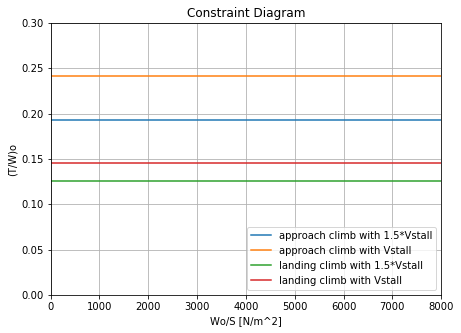

In [15]:
# plot approach climb and landing climb
fig = plt.figure(figsize=(7,5))

# approach climb with 1.5*Vstall
plt.plot(WSo, TW_approachclimb, label="approach climb with 1.5*Vstall")
# approach climb with Vstall
plt.plot(WSo, TW_approachclimb_vstall, label="approach climb with Vstall")

# landing climb with 1.5*Vstall
plt.plot(WSo, TW_landingclimb, label="landing climb with 1.5*Vstall")
# landing climb with Vstall
plt.plot(WSo, TW_landingclimb_vstall, label="landing climb with Vstall")


# PLOT SETTINGS
ax = plt.gca()
ax.set(xlim=(0, 8000), ylim=(0, 0.3)) 
plt.xlabel('Wo/S [N/m^2]')
plt.ylabel('(T/W)o')
plt.title('Constraint Diagram')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [16]:
# ===================================================================== #
# cruise
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(35000*ft2m)
rho = atmosphere.rho
n = 1 # approx.
CLmax, Cdo, e = flap(config='clean', gear=False)
#Vstall = np.sqrt(2*WSo/(rho*CLmax))  # Vstall = fn(WSo)
Minf  = 0.75
ainf  = 296.535
Vinf  = Minf*ainf
dhdt = 0
dvdt = 0
alpha = alpha_list[2]
beta = calc_beta(35000*ft2m) 
TW_cruise = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
#tmp = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))


### Loiter
Assume load factor $n$, then
$n = \dfrac{L}{mg} = \dfrac{1}{\cos(\theta)}$

also from horizontal equilibrium

$m\omega^2 R = L\sin(\theta)$

$R\omega^2 = \dfrac{L}{mg}g \sin(\theta)$

$R = \dfrac{n g \sin(\theta)}{\omega^2}$


In [17]:
# ===================================================================== #
# loiter
# >> 3 degrees per second turn
atmosphere = fluids.atmosphere.ATMOSPHERE_1976(1500)
rho = atmosphere.rho
n = 1.2   # FIXME - guessed load factor for loiter
print(f'prescribed load factor: {n}')
theta = np.arccos(1/n) # [rad]
print(f'bank angle: {theta*180/np.pi:.3f} [deg]')
omega = 3 * np.pi/180   #prescribed 3 degrees per second turn [rad/sec]
R = n*g*np.sin(theta)/(omega**2)
print(f'turn radius: {R/1000:.3f} [km]')

CLmax, Cdo, e = flap(config='clean', gear=False)
Vinf  = omega*R
print(f'Vinf during loiter: {Vinf:.3f} [m/s] or {Vinf*ms2knots:.3f} [knots]')
dhdt = 0
dvdt = 0
alpha = alpha_list[6]
beta = calc_beta(1500)
TW_loiter = TWvsWS(WSo,alpha,beta,dhdt,dvdt,rho,Vinf,Cdo,n,AR,e) 
#tmp = alpha/beta * (((1/Vinf)*dhdt) + ((1/g)*(dvdt)) + ((.5*rho*Vinf**2*Cdo)/(alpha*WSo)) + ((alpha*n**2*WSo)/(.5*rho*Vinf**2*np.pi*AR*e)))

prescribed load factor: 1.2
bank angle: 33.557 [deg]
turn radius: 2.374 [km]
Vinf during loiter: 124.279 [m/s] or 241.578 [knots]


In [18]:
# other aircrafts design points
# >> plot other aircraft's design points for reference


## Constraint Diagram

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Picked T/W: [0.3377680119751228]


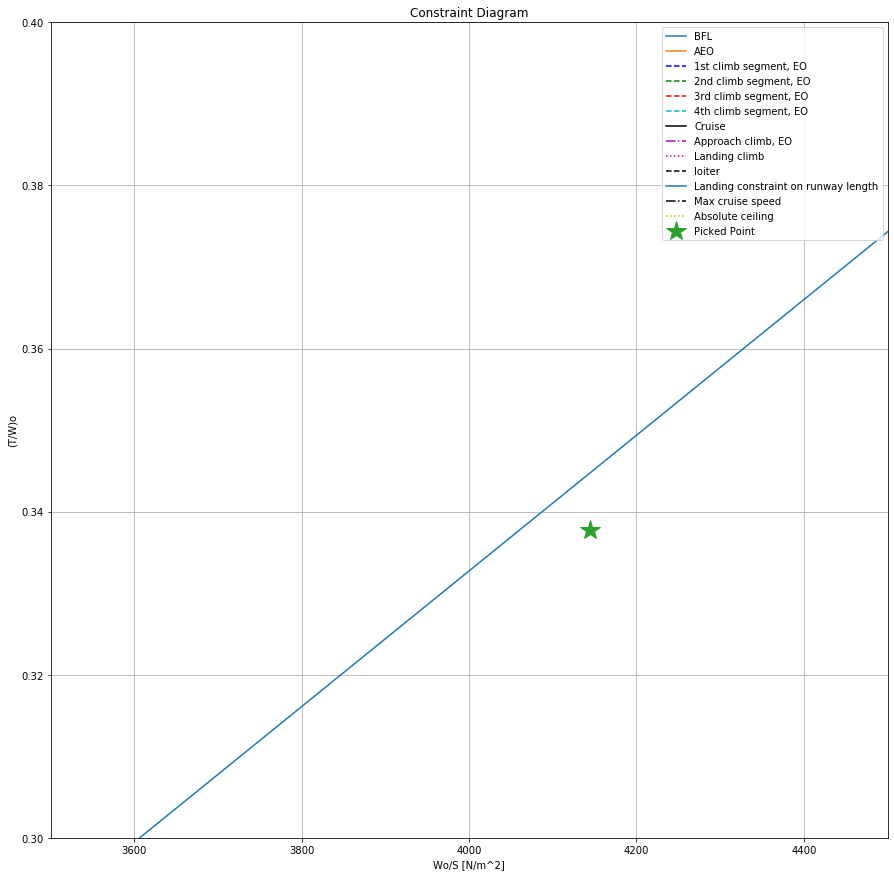

Minimum T/W: [0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915 0.24049915
 0.24049915 0.24049915 0.24049915 0.24049915 0.24

In [26]:
# ========== CONSTRAINT DIAGRAM ========== 
fig = plt.figure(figsize=(15,15))

# climb segment 1
#plt.plot(WSo, TW_climb1, 'b-', label="1st climb segment")
# climb segment 2
#plt.plot(WSo, TW_climb2, 'g-', label="2nd climb segment")
# climb segment 3
#plt.plot(WSo, TW_climb3, 'r-', label="3rd climb segment")
# climb segment 4
#plt.plot(WSo, TW_climb4, 'c-', label="4th climb segment")

plt.plot(WSo, TW_BFL, label='BFL')
plt.plot(WSo, TW_AEO, label='AEO')

# climb segment 1, EO
plt.plot(WSo, TW_climb1_EO, 'b--', label="1st climb segment, EO")
# climb segment 2 EO
plt.plot(WSo, TW_climb2_EO, 'g--', label="2nd climb segment, EO")
# climb segment 3, EO
plt.plot(WSo, TW_climb3_EO, 'r--', label="3rd climb segment, EO")
# climb segment 4, EO
plt.plot(WSo, TW_climb4_EO, 'c--', label="4th climb segment, EO")

# Cruise
plt.plot(WSo, TW_cruise, 'k-', label="Cruise")

# approach climb
plt.plot(WSo, TW_approachclimb, 'm-.', label="Approach climb, EO")

# landing climb (gear down)
plt.plot(WSo, TW_landingclimb, 'm:', label="Landing climb")

# loiter 1
plt.plot(WSo, TW_loiter, 'k--', label="loiter")

# landing req
plt.axvline(x = WS_landing, label='Landing constraint on runway length')

# max cruise speed
plt.plot(WSo, TW_cruise_max_speed, 'k-.', label="Max cruise speed")

# Abs ceiling
plt.plot(WSo, TW_absceil, 'y:', label="Absolute ceiling")


# DESIGN POINT - plot picked point:
Ttakeoff = 29.8*1000      # take-off thrust per engine - Lycoming ALF502 R-3 [N]
Thrustpoint = 2*Ttakeoff
Wtakeoff = 17987*9.81   # max. take-off weight [N]

WSo_picked = [4000]
TW_picked = [Thrustpoint/Wtakeoff]
#TW_picked = 
print(f'Picked T/W: {TW_picked}')

plt.plot(WSo_picked, TW_picked, '*', label='Picked Point', markersize=20)


# PLOT SETTINGS
ax = plt.gca()
ax.set(xlim=(0, 5000), ylim=(0, 0.5)) 
plt.xlabel('Wo/S [N/m^2]')
plt.ylabel('(T/W)o')
plt.title('Constraint Diagram')
plt.legend(loc='upper right')
plt.grid()

# save constraint diagram as .eps file
plt.savefig('constraint_diagram.eps', format='eps') # save as eps
plt.xlim([3500,4500])
plt.ylim([0.3,0.4])
plt.show()


#ENGINE SELECTION
print(f'Minimum T/W: {TW_absceil}')
print(f'Takeoff weight: {Wtakeoff} N')
minThrust = (TW_absceil * Wtakeoff)/2   # per engine
print(minThrust)



In [20]:
TW_climb1_EO

array([0.23856892, 0.23951692, 0.24046491, 0.2414129 , 0.2423609 ,
       0.24330889, 0.24425688, 0.24520488, 0.24615287, 0.24710087,
       0.24804886, 0.24899685, 0.24994485, 0.25089284, 0.25184083,
       0.25278883, 0.25373682, 0.25468481, 0.25563281, 0.2565808 ,
       0.2575288 , 0.25847679, 0.25942478, 0.26037278, 0.26132077,
       0.26226876, 0.26321676, 0.26416475, 0.26511275, 0.26606074,
       0.26700873, 0.26795673, 0.26890472, 0.26985271, 0.27080071,
       0.2717487 , 0.2726967 , 0.27364469, 0.27459268, 0.27554068,
       0.27648867, 0.27743666, 0.27838466, 0.27933265, 0.28028065,
       0.28122864, 0.28217663, 0.28312463, 0.28407262, 0.28502061,
       0.28596861, 0.2869166 , 0.2878646 , 0.28881259, 0.28976058,
       0.29070858, 0.29165657, 0.29260456, 0.29355256, 0.29450055,
       0.29544855, 0.29639654, 0.29734453, 0.29829253, 0.29924052,
       0.30018851, 0.30113651, 0.3020845 , 0.30303249, 0.30398049,
       0.30492848, 0.30587648, 0.30682447, 0.30777246, 0.30872

In [21]:
TW_climb2_EO

array([0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918083,
       0.23918083, 0.23918083, 0.23918083, 0.23918083, 0.23918

In [22]:
# calculation of aircraft parameters
Sref = Wtakeoff/WSo_picked[0]
B = np.sqrt(Sref*AR)     # wingspan
Mac = Sref/B
print(f'Sref: {Sref} [m^2]')
print(f'Wingspan: {B} [m]')
print(f'Mean aerodynamic chord: {Mac} [m]')


Sref: 42.56995657418577 [m^2]
Wingspan: 18.454258386439868 [m]
Mean aerodynamic chord: 2.306782298304983 [m]


In [23]:
# POINT PERFORMANCE

#alpha  = 0.23
#beta   = 0.96
#f0     = 9000
#w0     = 10000
#dhdt   = 10668/9 #m/s
#Cd0    = 0.2
#e      = 0.9
#rho    = 0.3795


#TW_M2  = []
#TW_M4  = []
#TW_M6  = []
#TW_M8  = []

#W0_S = np.linspace(0.1,2,9)

#for i in W0_S:
#    
 #     TW_M2 = (beta/2) * (rho*(.2*296.54)**2*Cd0/W0_S)
  #    TW_M4 = (beta/2) * (rho*(.4*296.54)**2*Cd0/W0_S)
   #   TW_M6 = (beta/2) * (rho*(.6*296.54)**2*Cd0/W0_S)
    #  TW_M8 = (beta/2) * (rho*(.8*296.54)**2*Cd0/W0_S)

#plt.plot(W0_S, TW_M2, label="M=0.2") 
#plt.plot(W0_S, TW_M4, label="M=0.4") 
#plt.plot(W0_S, TW_M6, label="M=0.6") 
#plt.plot(W0_S, TW_M8, label="M=0.8") 
#plt.legend(loc='upper right')
#plt.xlabel('Wing loading Wo/S (n/m2)')
#plt.ylabel('Thrust/Weight (To/Wo)')
#plt.title('Steady Level Flight @ different Mach')
#plt.grid()
#plt.show() 

#n = 1
#for i in W0_S:
    
#      TW_M22 = (alpha/beta) * ((rho*(.2*296.54)**2*Cd0/W0_S*2*alpha) + (alpha*n**2*W0_S*2/rho*(.2*296.54)**2*3.14*AR*e))
#      TW_M42 = (alpha/beta) * ((rho*(.4*296.54)**2*Cd0/W0_S*2*alpha) + (alpha*n**2*W0_S*2/rho*(.4*296.54)**2*3.14*AR*e))
#      TW_M62 = (alpha/beta) * ((rho*(.6*296.54)**2*Cd0/W0_S*2*alpha) + (alpha*n**2*W0_S*2/rho*(.6*296.54)**2*3.14*AR*e))
#      TW_M82 = (alpha/beta) * ((rho*(.8*296.54)**2*Cd0/W0_S*2*alpha) + (alpha*n**2*W0_S*2/rho*(.8*296.54)**2*3.14*AR*e))

#plt.plot(W0_S, TW_M22, label="M=0.2") 
#plt.plot(W0_S, TW_M42, label="M=0.4") 
#plt.plot(W0_S, TW_M62, label="M=0.6") 
#plt.plot(W0_S, TW_M82, label="M=0.8") 

# PLOT FOR VERYING AR, W/Wo, n, here assumed that n=0 as steady level flight only

In [24]:
# REDIFINE ALPA/BETA FOR EACH SEGMENT?